# The Kyle Model
--------------------------------------------------------------------------------------------------------------------------------------

### Goal
To analyze the process of price discovery – how private information becomes incorporated into asset prices – within a simplified multi-period extension of the Kyle (1985) model.

### Core Questions
- In a 2- or 3-period Kyle model with a known range for the final asset value, how does the market maker’s optimal pricing rule (specifically, the price impact parameter λ) evolve from period to period?
- How does this dynamic process of information revelation differ from the static single-period case?

### Definition
The **Kyle model**, introduced by **Albert S. Kyle** in his seminal 1985 paper *“Continuous Auctions and Insider Trading”*, is a foundational model in market microstructure theory. It provides a framework for understanding how **private information is gradually incorporated into asset prices through trading** in financial markets.

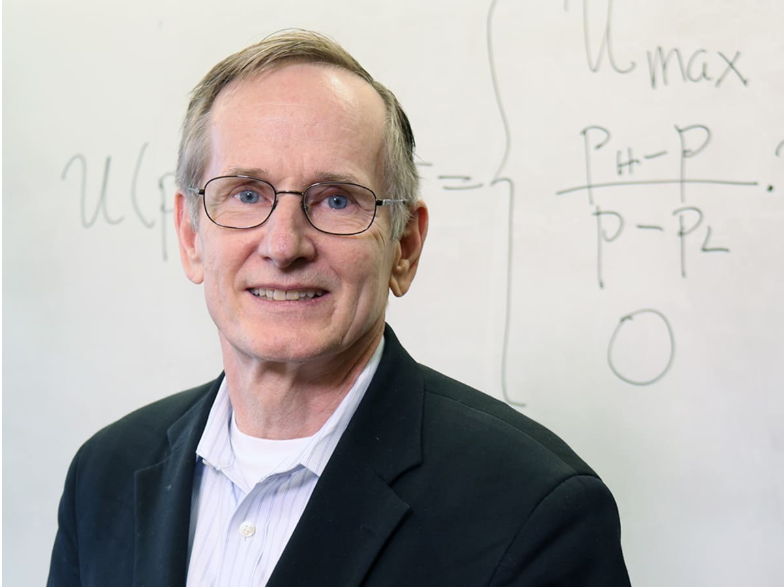

There are three agents in this simplified framework:
- **Informed trader (insider)**: Has private knowledge of the true value $\tilde{v}$, and trades strategically to profit from this information.
- **Noise traders**: Submit random buy or sell orders unrelated to $\tilde{v}$, typically modeled as Gaussian noise.
- **Market maker**: Observes only the total order flow (informed + noise) and sets the market-clearing price using Bayesian inference.

Since the market maker cannot observe which trades are informed, prices are set based on the expected value of the asset conditional on the observed order flow. This leads to a **linear equilibrium** in which the price partially reveals private information. In a multi-period extension, this mechanism enables the gradual incorporation of information into prices over time.

## Dependencies loading
--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

import plotly
from IPython.display import display, HTML

plotly.offline.init_notebook_mode()
display(
    HTML(
        '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
    )
)  # for latex in plotly labels

random_seed = 42

PLOTLY_FIG_HEIGHT = 250

## Single-Period Model ($N = 1$)
--------------------------------------------------------------------------------------------------------------------------------------

In the single-period Kyle model, all trading occurs in one round. The informed trader knows the true value of the asset and chooses a single trade to maximize profit, while the market maker sets the price based on total observed order flow.

### Assumptions

1) The model describes a single trading period. At the beginning of the period, agents trade a risky asset with a random liquidation value at the end of the period, denoted by $\tilde{v} \sim \mathcal{N}(p_0, \Sigma_0)$.


2) **Noise traders** have needs to trade that are exogenous to the model. It is simply assumed that they, as a group, submit a market order to buy $\tilde{u}$ shares of the asset, where $\tilde{u} \sim \mathcal{N}(0, \sigma_u^2)$.
The variables $\tilde{u}$ and $\tilde{v}$ are assumed to be independently distributed.

3) There is a single **risk-neutral informed trader (insider)** that is assumed to have better information than the other agents.  
He knows with perfect certainty the realized end-of-period value of the risky security $ \tilde{v} $ (but not $ \tilde{u} $), and chooses to submit a market order of size $ x $ that maximizes his expected end-of-period profits.


4) The single risk-neutral **market maker** receives the market orders submitted by the noise traders and the insider, which in total equal $ u + x $. Importantly, the market maker cannot distinguish what part of this total order consists of orders made by noise traders and what part consists of the order of the insider (the traders are anonymous).

Now that the assumptions are established, we derive the equilibrium strategies of both the informed trader and the market maker under this single-period setup.

### Parameter Setup

In [ ]:
asset_mean = 100.0  # prior mean of the true asset value
asset_stdev = 2.5  # std. dev. of the true asset value (σ_v)
apriori_sigma0 = asset_stdev ** 2
uninf_stdev = 5.0  # std. dev. of noise trader orders (σ_u)

# for lambda surface and plots
asset_stdevs = np.arange(0.5, 5.01, 0.1)
uninformed_stdevs = np.arange(2.0, 10.1, 0.1)

# for multiperiod model
kyle_periods = 3
n_of_informed = 5
kyle_periods_list = np.arange(1, 11, 1)
n_of_informed_list = np.arange(1, 16, 1)

### Lambda & Beta Calculation

**Experiment setup:** generate true value of an asset with the same mean but different standard deviations, from small to large. These are $p_0$ and $\sqrt\Sigma_0$ from the theorem. Uninformed traders have order flow with mean $0$ and stdev $\sigma_u$.

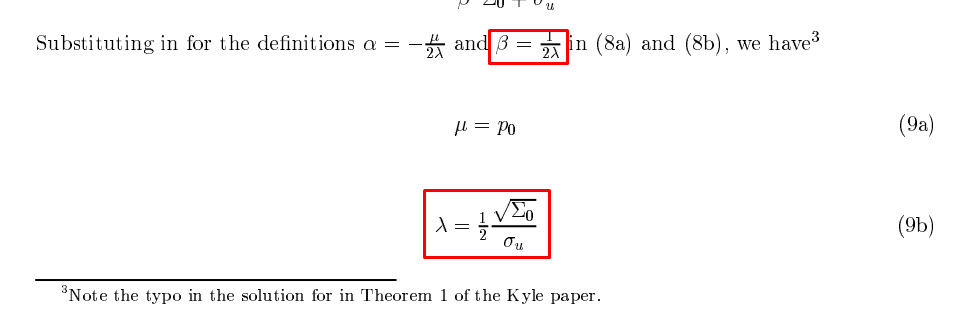

In [ ]:
def get_kyle1_params(
    true_asset_stdev: float, uninf_stdev: float
) -> tuple[float, float]:
    lmbd = true_asset_stdev / (2 * uninf_stdev)
    beta = 1 / (2 * lmbd)

    return lmbd, beta


def get_kyle1_lambda(asset_stdev, uninf_stdev):
    return asset_stdev / (2 * uninf_stdev)


def get_kyle1_quotes(
    guess_price: float,
    market_maker_spread: float,
    true_asset_value: float,
    true_asset_stdev: float,
    uninf_stdev: float,
    iterations=100,
    adjustment=None,
    param_fn=None,
    M=1
):
    order_flow = []

    market_maker_quotes = [
        (guess_price + market_maker_spread, guess_price - market_maker_spread)
    ]

    if param_fn is None:
        lmbd = true_asset_stdev / (2 * uninf_stdev)
        beta = 1 / (2 * lmbd)
    else:
        lmbd, beta = param_fn(true_asset_stdev, uninf_stdev, M)

    for _ in range(iterations):
        midprice = (market_maker_quotes[-1][0] + market_maker_quotes[-1][1]) / 2
        uninformed_trader_of = np.random.normal(0, uninf_stdev)
        informed_trader_of = beta * (true_asset_value - midprice)

        total_order_flow = uninformed_trader_of + M * informed_trader_of

        # update market maker quotes

        last_bid = market_maker_quotes[-1][0]
        last_ask = market_maker_quotes[-1][1]

        if adjustment is None:
            price_adjustment = lmbd * total_order_flow  # linear Kyle model
        else:
            price_adjustment = adjustment(total_order_flow, lmbd)

        new_bid, new_ask = last_bid + price_adjustment, last_ask + price_adjustment

        order_flow.append(total_order_flow)
        market_maker_quotes.append((new_bid, new_ask))

    return market_maker_quotes, lmbd, beta

The plot below shows how these quotes converge toward the true asset value:

In [ ]:
np.random.seed(random_seed)

n_iters = 50

true_asset_value = np.random.normal(asset_mean, asset_stdev)
market_maker_quotes, lmbd, beta = get_kyle1_quotes(
    110, 2, true_asset_value, asset_stdev, uninf_stdev, n_iters
)

print(f"Lambda={lmbd}, beta={beta}")

bids = [x[0] for x in market_maker_quotes]
asks = [x[1] for x in market_maker_quotes]

# plot bids and asks

kyle1m_fig = go.Figure()

kyle1m_fig.add_trace(
    go.Scatter(x=list(range(n_iters)), y=bids, mode="lines+markers", name="Bids")
)
kyle1m_fig.add_trace(
    go.Scatter(x=list(range(n_iters)), y=asks, mode="lines+markers", name="Asks")
)
kyle1m_fig.add_hline(
    y=true_asset_value,
    line_dash="dot",
    yanchor="top",
    annotation_text=f"True asset value: {true_asset_value:.2f}",
    annotation_position="bottom right",
)

kyle1m_fig.show()

### Surface of lambdas

In [ ]:
assets_x, uninfs_y = np.meshgrid(asset_stdevs, uninformed_stdevs)
lmbd_z = get_kyle1_lambda(assets_x, uninfs_y)

lmbd_fig = go.Figure(
    go.Surface(x=assets_x, y=uninfs_y, z=lmbd_z, colorbar_thickness=24)
)

lmbd_fig.update_layout(
    title=dict(text="Lambda Surface"),
    width=600,
    height=600,
    font_size=12,
    scene=dict(
        xaxis=dict(title="Asset StDev"),
        yaxis=dict(title="Uninformed StDev"),
        zaxis=dict(title="Lambda"),
    ),
)

lmbd_fig.show()

- **λ increases with asset uncertainty**: When the asset’s value is more uncertain, the insider’s information is more valuable - the market maker reacts more strongly to order flow.
- **λ decreases with noise**: Higher noise trader activity makes order flow less informative - the market maker adjusts prices more cautiously.

### Other Adjustments

In [ ]:
def sqrt_adjustment(total_order_flow, lmbd):
    return lmbd * np.sign(total_order_flow) * np.sqrt(1 + abs(total_order_flow))


def squared_adjustment(total_order_flow, lmbd):
    return (
        lmbd * np.sign(total_order_flow) * np.minimum((abs(total_order_flow)) ** 2, 10)
    )


def log_adjustment(total_order_flow, lmbd):
    return lmbd * np.sign(total_order_flow) * np.log(1 + abs(total_order_flow))


def exp_adjustment(total_order_flow, lmbd):
    return (
        lmbd
        * np.sign(total_order_flow)
        * np.minimum(np.exp(abs(total_order_flow)) - 1, 10.0)
    )


def power_law_adj(total_order_flow, lmbd, gamma, alpha):
    return alpha * lmbd * np.sign(total_order_flow) * (abs(total_order_flow) ** gamma)

In [ ]:
# define adjustment functions
adjustments = {
    "Kyle": None,
    "Sqrt": sqrt_adjustment,
    "Squared": squared_adjustment,
    "Log": log_adjustment,
    "Exp": exp_adjustment,
    "Power-Law": lambda of_, lmbd: power_law_adj(of_, lmbd, gamma=0.6, alpha=0.5),
}

np.random.seed(random_seed)
true_asset_value = np.random.normal(asset_mean, asset_stdev)

adj_fn_fig = go.Figure()

for name, adj_func in adjustments.items():
    market_maker_quotes, _, _ = get_kyle1_quotes(
        110, 2, true_asset_value, asset_stdev, uninf_stdev, n_iters, adjustment=adj_func
    )

    bids = [x[0] for x in market_maker_quotes]
    asks = [x[1] for x in market_maker_quotes]

    adj_fn_fig.add_trace(
        go.Scatter(
            x=list(range(n_iters + 1)), y=bids, mode="lines", name=f"Bids - {name}"
        )
    )
    adj_fn_fig.add_trace(
        go.Scatter(
            x=list(range(n_iters + 1)), y=asks, mode="lines", name=f"Asks - {name}"
        )
    )

adj_fn_fig.add_hline(
    y=true_asset_value,
    line_dash="dot",
    yanchor="top",
    annotation_text=f"True asset value: {true_asset_value:.2f}",
    annotation_position="bottom right",
)

adj_fn_fig.show()

Concave adjustments, such as the **logarithmic** and **square root** functions, make prices adjust more **smoothly and cautiously**. They reduce the impact of big trades, leading to a **more stable and less volatile** path toward the fair price. These are **less aggressive** than the classic **Kyle equilibrium**, which uses a **linear adjustment** rule.

On the other hand, convex adjustments like the **squared** and **exponential** functions react **more agressively** to large trades. This can make prices **move faster** toward the true value, but also introduces **more noise and instability**, especially when order flow is unpredictable.

The **power-law adjustment** lets us explore the balance between **stability** and **convergence** by tuning two parameters. **Alpha** controls the intensity of the adjustment, while **gamma** shapes its **nonlinearity** — with gamma < 1 acting like a concave rule and gamma > 1 like a convex one. This helps us smoothly shift between different market behaviors.

## Holden & Subrahmanyam (1992) — Single-Period Equilibrium with Multiple Informed Traders
--------------------------------------------------------------------------------------------------------------------------------------

This extension generalizes the Kyle (1985) model to include **$M \geq 1$** risk-neutral informed traders who compete strategically in a single trading period.

### Assumptions

- A single risky asset with liquidation value $v \sim \mathcal{N}(\mu, \sigma_v^2)$.
- $M$ informed traders observe the true value $v$ and simultaneously submit market orders $x_i$.
- Noise traders submit orders $u \sim \mathcal{N}(0, \sigma_u^2)$, independent of $v$.
- A competitive, risk-neutral market maker observes only total order flow $y = \sum x_i + u$ and sets the price $p = \mathbb{E}[v \mid y]$.
- Traders adopt linear strategies $x_i = \beta(v - p)$, and the market maker uses a pricing rule $p = \mu + \lambda y$.

### Equilibrium Solution

$$
\lambda = \frac{1}{\sigma_u} \sqrt{\frac{M \sigma_v^2}{M + 1}}, \quad 
\beta = \frac{1}{\lambda (M + 1)}
$$

As $M$ increases, **price impact decreases** and the market becomes **more efficient**.

In [ ]:
def get_hs1_params(true_asset_stdev, uninf_stdev, M):
    lambda_hs = (1 / uninf_stdev) * (np.sqrt(M) * true_asset_stdev) / np.sqrt(M + 1)
    beta_hs = 1 / (lambda_hs * (M + 1))
    return lambda_hs, beta_hs

In [ ]:
M = np.arange(1, 31)

lambdas = [get_hs1_params(asset_stdev, uninf_stdev, m)[0] for m in M]
betas = [get_hs1_params(asset_stdev, uninf_stdev, m)[1] for m in M]

lmbd_fig = go.Figure()

lmbd_fig.add_trace(go.Scatter(x=M, y=lambdas, mode='lines+markers', name='Lambda (λ)'))
lmbd_fig.add_trace(go.Scatter(x=M, y=betas, mode='lines+markers', name='Beta (β)'))

lmbd_fig.update_layout(
    xaxis_title='Number of Informed Traders (M)',
    yaxis_title='Parameters',
    height=700,
    width=1000,
    legend=dict(x=1,y=1)
)

lmbd_fig.show()

As the number of informed traders (M) increases, **lambda (λ)** rises but more slowly, meaning prices react less strongly to each new trader. **Beta (β)** drops quickly, showing that each trader becomes less aggressive. After around 
**M>10**, both values level off, meaning adding more informed traders has little extra effect.

In [ ]:
np.random.seed(random_seed)

n_iters = 50

quotes_kyle, _, _ = get_kyle1_quotes(
    110, 2, true_asset_value, asset_stdev, uninf_stdev, n_iters)
quotes_hs, _, _ = get_kyle1_quotes(
    110, 2, true_asset_value, asset_stdev, uninf_stdev, n_iters, param_fn=get_hs1_params, M=3)

bids = [x[0] for x in quotes_kyle]
asks = [x[1] for x in quotes_kyle]

kyle_hs_fig = go.Figure()

kyle_hs_fig.add_trace(
    go.Scatter(x=list(range(n_iters + 1)), y=bids, mode="lines", name="Kyle - Bids"))
kyle_hs_fig.add_trace(
    go.Scatter(x=list(range(n_iters + 1)), y=asks, mode="lines", name="Kyle - Asks"))

bids_hs = [x[0] for x in quotes_hs]
asks_hs = [x[1] for x in quotes_hs]

kyle_hs_fig.add_trace(
    go.Scatter(x=list(range(n_iters + 1)), y=bids_hs, mode="lines", name="HS - Bids (M=3)"))
kyle_hs_fig.add_trace(
    go.Scatter(x=list(range(n_iters + 1)), y=asks_hs, mode="lines", name="HS - Asks (M=3)"))

kyle_hs_fig.add_hline(
    y=true_asset_value,
    line_dash="dot",
    yanchor="top",
    annotation_text=f"True asset value: {true_asset_value:.2f}",
    annotation_position="bottom right",
)

kyle_hs_fig.show()

Both the **Kyle** and **Holden–Subrahmanyam (HS)** models move prices towards the true asset value, but the HS model adjusts a bit faster at the start. With multiple informed traders in the HS setup, prices tend to swing more, showing slightly greater volatility due to stronger competition. These traders act more aggressively to use their information before others do. The HS model also starts with quotes closer to the fair value, showing more pricing efficiency. Overall, adding more informed traders makes the market react faster to information.

In [ ]:
np.random.seed(random_seed)

n_iters = 50
hs_fig = go.Figure()

for M in range(1, 14, 3):
    quotes_hs, _, _ = get_kyle1_quotes(
        110, 2, true_asset_value, asset_stdev, uninf_stdev,
        iterations=n_iters, param_fn=get_hs1_params, M=M)
    
    bids = [x[0] for x in quotes_hs]
    asks = [x[1] for x in quotes_hs]

    hs_fig.add_trace(go.Scatter(x=list(range(n_iters + 1)), y=bids, mode="lines", name=f"HS - Bids (M={M})"))
    hs_fig.add_trace(go.Scatter(x=list(range(n_iters + 1)), y=asks, mode="lines", name=f"HS - Asks (M={M})"))

hs_fig.add_hline(
    y=true_asset_value,
    line_dash="dot",
    annotation_text=f"True asset value: {true_asset_value:.2f}",
    annotation_position="bottom right",
)

hs_fig.show()

As already shown in the plots above, as the number of informed traders increases, the effects on lambda become progressively smaller. This indicates diminishing marginal influence on price informativeness. Consequently, after 
M>5, the additional impact on how quickly prices move toward the true asset value becomes almost unnoticeable.

# Multi-Period Kyle Model (N = 3)

At every iteration, for each period, solve cubic equation (take the second largest root):

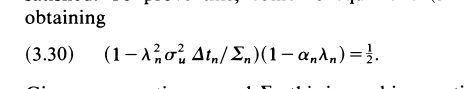

Expanded:

$$
\dfrac{\alpha_n \sigma_u^2 \Delta t}{\Sigma_n}\lambda_n^3 - \dfrac{\sigma_u^2 \Delta t}{\Sigma_n}\lambda_n^2 - \alpha_n\lambda_n + \dfrac{1}{2} = 0
$$

The idea is to solve the system backwards, from $N$ to $1$, in search for $\lambda_n$. Kyle proved that the second largest root is the one that should be taken. The smallest root is negative, and the largest is not satisfying second order condition.

For each iteration $n$, assume we already have $\alpha_n$ and $\Sigma_n$ calculated. We solve the equation for $\lambda_n$, and then calculate $\beta_n$, $\alpha_{n-1}$ and $\Sigma_{n-1}$ from $\lambda_n$ with the help of this difference equation system:

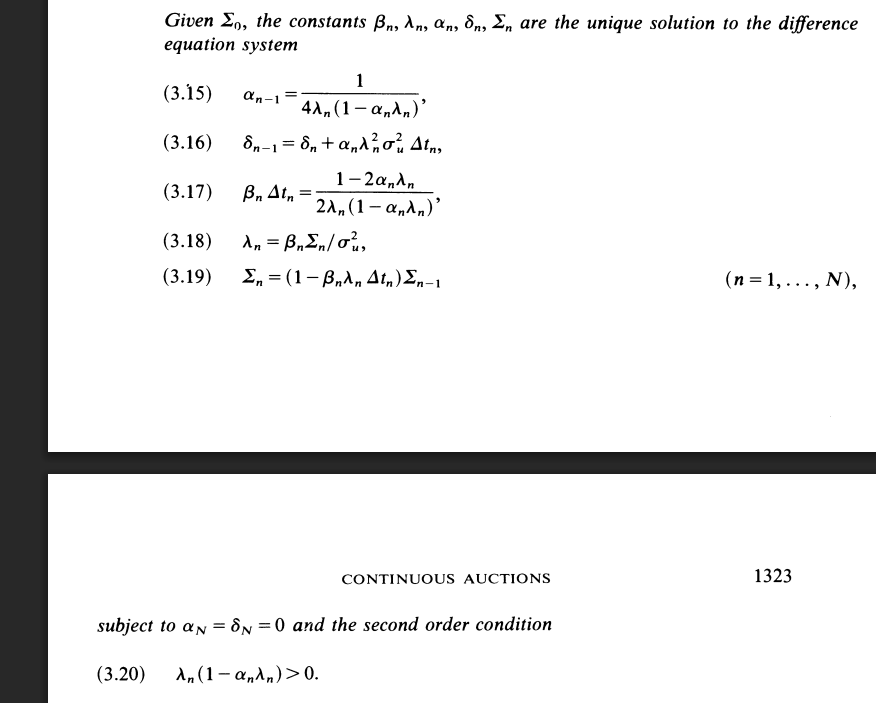

The main issue that, although $\alpha_N = 0$, we don't know the value of $\Sigma_N$, and it should be searched for by utilizing methods of finding function roots, like bisection or Newton-Raphson.

In [ ]:
from scipy.optimize import root_scalar


class MultiPeriodKyleModel:
    def __init__(self, N: int, apriori_stdev: float, uninf_stdev: float):
        self.dt = 1 / N
        self.uninf_stdev = uninf_stdev
        self.apriori_stdev = apriori_stdev
        self.N = N

    def fit(self, xtol: float = 1e-6, is_silent=True):

        root_results = root_scalar(
            self._perform_one_run,
            method='bisect',
            bracket=[1e-6, self.apriori_stdev],
            xtol=xtol,
            args=(is_silent,),
        )

        if not is_silent:
            print(f"apriori stdev: true={self.apriori_stdev}, fit={self.SIGMA_0**0.5}")

        return self

    def _init_params(self, final_stdev_guess: float):
        self.ALPHA = np.zeros(self.N)
        self.BETA = np.zeros(self.N)
        self.LAMBDA = np.zeros(self.N)
        self.SIGMA = np.zeros(self.N)

        self.SIGMA[self.N - 1] = final_stdev_guess**2

    def _perform_one_run(self, final_stdev_guess: float, is_silent: bool):
        self._init_params(final_stdev_guess)

        for n in range(self.N - 1, -1, -1):
            lmbd_roots = np.roots(
                [
                    self.ALPHA[n] * self.uninf_stdev**2 * self.dt / self.SIGMA[n],
                    -self.uninf_stdev**2 * self.dt / self.SIGMA[n],
                    -self.ALPHA[n],
                    0.5,
                ]
            )

            if (
                len(lmbd_roots) < 3
            ):  # if alpha=0, then we have two roots, positive and negative
                self.LAMBDA[n] = max(lmbd_roots)
            else:
                self.LAMBDA[n] = np.median(
                    lmbd_roots
                )  # the second largest, out of three, according to the paper

            # use lambda to calculate beta, and next step alpha and sigma
            self.BETA[n] = self.LAMBDA[n] * self.uninf_stdev**2 / self.SIGMA[n]

            if n > 0:
                self.SIGMA[n - 1] = self.SIGMA[n] / (
                    1 - self.BETA[n] * self.LAMBDA[n] * self.dt
                )
                self.ALPHA[n - 1] = 1 / (
                    4 * self.LAMBDA[n] * (1 - self.ALPHA[n] * self.LAMBDA[n])
                )
            else:
                self.SIGMA_0 = self.SIGMA[n] / (
                    1 - self.BETA[n] * self.LAMBDA[n] * self.dt
                )

        if not is_silent:
            print(f"current Sigma_0={self.SIGMA_0}, apriori={self.apriori_stdev**2}")
            print(f"beta={self.BETA}, sigma={self.SIGMA}, lambda={self.LAMBDA}")

        return self.SIGMA_0 - self.apriori_stdev**2

Here, we check how the convergence of bisection method works.

In [ ]:
kyle3_model = MultiPeriodKyleModel(kyle_periods, asset_stdev, uninf_stdev).fit(
    is_silent=False
)

In [ ]:
def plot_multiperiod_parameters(
    x_data, params_data, x_data_name: str, param_name: str, plot_title: str, period_name: str, save_path: str
):
    multiperiod_fig = go.Figure()

    for param_n, vals in enumerate(params_data):
        multiperiod_fig.add_trace(
            go.Scatter(x=x_data, y=vals, mode="lines+markers", name=f"{period_name}={param_n+1}")
        )

    multiperiod_fig.update_layout(
        # title=dict(text=plot_title),
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        height=PLOTLY_FIG_HEIGHT,
        xaxis=dict(title=dict(text=x_data_name)),
        yaxis=dict(title=dict(text=param_name)),
        barmode="stack",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
    )
    multiperiod_fig.show()

    if save_path:
        multiperiod_fig.write_image(save_path)

## Dependency on $N$

Let's check what happens if we increase the number of auctions.

In [ ]:
lmbd_by_N = np.empty(shape=(len(kyle_periods_list), len(kyle_periods_list)), dtype=np.float64) * np.nan
beta_by_N = np.empty(shape=(len(kyle_periods_list), len(kyle_periods_list)), dtype=np.float64) * np.nan
sigma_by_N = np.empty(shape=(len(kyle_periods_list), len(kyle_periods_list)), dtype=np.float64) * np.nan

for kyle_idx, kyle_p in enumerate(kyle_periods_list):
    model = MultiPeriodKyleModel(kyle_p, asset_stdev, uninf_stdev).fit()

    for param_n, (lmbd, beta, sigma) in enumerate(
        zip(model.LAMBDA, model.BETA, model.SIGMA)
    ):
        lmbd_by_N[kyle_idx][param_n] = lmbd
        beta_by_N[kyle_idx][param_n] = beta
        sigma_by_N[kyle_idx][param_n] = sigma

In [ ]:
def plot_kyle_params_by_N(
    kyle_periods_list, params_data, x_data_name: str, param_name: str, plot_title: str, period_name: str, path_to_save: str
):
    kyle_N_fig = go.Figure()

    for kyle_idx, kyle_p in enumerate(kyle_periods_list):
        kyle_N_fig.add_trace(
            go.Scatter(x=kyle_periods_list, y=params_data[kyle_idx], mode="lines+markers", name=f"{period_name}={kyle_idx+1}")
        )

    kyle_N_fig.update_layout(
        # title=dict(text=plot_title),
        xaxis=dict(title=dict(text=x_data_name)),
        yaxis=dict(title=dict(text=param_name)),
    )
    
    kyle_N_fig.update_layout(
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        height=PLOTLY_FIG_HEIGHT,
        barmode="stack",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
        )
    
    if path_to_save:
        kyle_N_fig.write_image(path_to_save)


    kyle_N_fig.show()

In [ ]:
plot_kyle_params_by_N(
    kyle_periods_list, 
    lmbd_by_N, 
    "n", 
    r"$\lambda_n$",
    f"Depth of the Market", 
    "N",
    "./presentation/figures/lambda_by_N.pdf"
)
plot_kyle_params_by_N(
    kyle_periods_list,
    beta_by_N,
    "n",
    r"$\beta_n$",
    f"Insider Trading Intensity",
    "N",
    "./presentation/figures/beta_by_N.pdf"
)
plot_kyle_params_by_N(
    kyle_periods_list,
    sigma_by_N,
    "n",
    r"$\Sigma_n$",
    f"Insider Information, a priori={apriori_sigma0}",
    "N",
    "./presentation/figures/sigma_by_N.pdf"
)

As expected, $\lambda_n$ is decreasing, BUT, interestingly, terminal values $\lambda_N$ are increasing with larger $N$. We can interpret it as that, since we have only one informed trader, it is able to reveal information much slower.

Trading intensity $\beta_n$ is increasing, but not very quickly, and terminal values $\beta_N$ are increasing linearly, it seems. Informed monopolist take their time to extract profits.

The same goes about private information decrease $\Sigma_n$: it decreases, but in a semi-linear fashion, and $\Sigma_N$ decrease with $N$ is slowed.

Later we will see how this situation changes drastically when we add at least one competitor for the informed trader.

## Dependency on $\sigma_u$

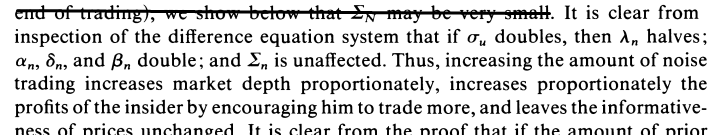

In [ ]:
lmbd_by_uninf = [[] for _ in range(kyle_periods)]
beta_by_uninf = [[] for _ in range(kyle_periods)]
sigma_by_uninf = [[] for _ in range(kyle_periods)]

for u_std in uninformed_stdevs:
    model = MultiPeriodKyleModel(kyle_periods, asset_stdev, u_std).fit()

    for param_n, (lmbd, beta, sigma) in enumerate(
        zip(model.LAMBDA, model.BETA, model.SIGMA)
    ):
        lmbd_by_uninf[param_n].append(lmbd)
        beta_by_uninf[param_n].append(beta)
        sigma_by_uninf[param_n].append(sigma)

In [ ]:
plot_multiperiod_parameters(
    uninformed_stdevs, 
    lmbd_by_uninf, 
    r"$\sigma_u$", 
    r"$\lambda_n$", 
    f"Depth of the Market, N={kyle_periods}",
    "n",
    "./presentation/figures/lambda_by_uninf.pdf"
)
plot_multiperiod_parameters(
    uninformed_stdevs,
    beta_by_uninf,
    r"$\sigma_u$",
    r"$\beta_n$",
    f"Insider Trading Intensity, N={kyle_periods}",
    "n",
    "./presentation/figures/beta_by_uninf.pdf"
)
plot_multiperiod_parameters(
    uninformed_stdevs,
    sigma_by_uninf,
    r"$\sigma_u$",
    r"$\Sigma_n$",
    f"Insider Information, N={kyle_periods}, a priori={apriori_sigma0}",
    "n",
    "./presentation/figures/sigma_by_uninf.pdf"
)

Kyle's conclusion about uninformed trader's volatility is confirmed by our modelling. With higher volatility of uninformed trading, market depth increases, informed trader's aggressiveness increases, but information reveal does not depend on $\sigma_u$.

# Several Informed Traders

HOLDEN and SUBRAHMANYAM, 1992

We assume that we have $M$ informed traders, so we have competition for private information reveal.

Firstly, the equilibrium conditions slightly change to incorporate $M$. We can check them in the presentation.

Secondly, H. and S. found a way to solve the system without guessing $\Sigma_N$, by applying exactly two passes.

The first, backward pass, is to solve a special cubic equation.

The second, forward, pass, is to obtain actual model parameters.

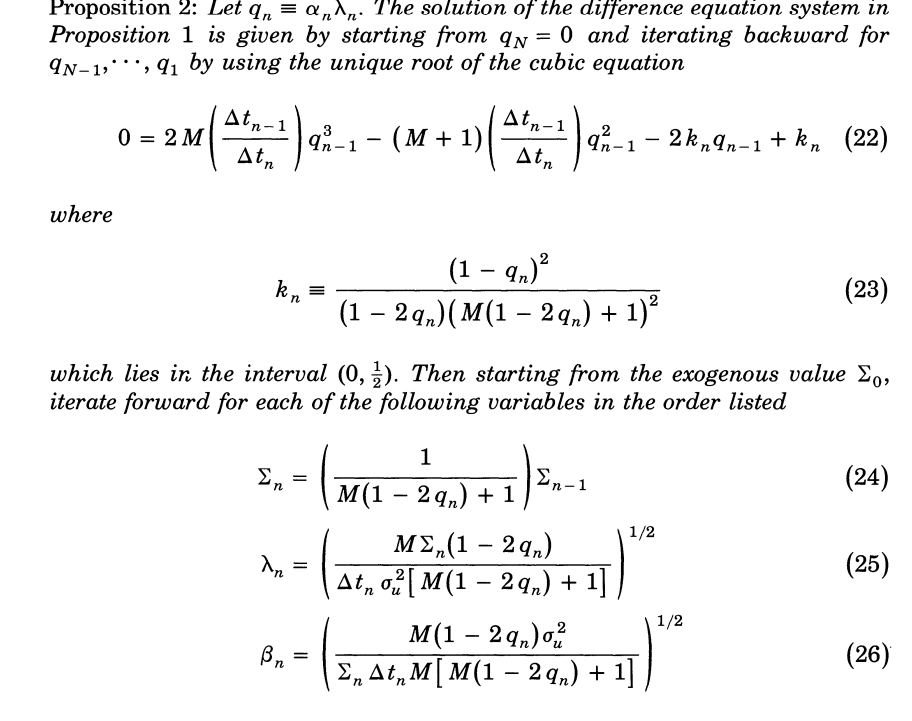

In [ ]:
class HoldenModel:
    def __init__(self, N: int, M: int, apriori_stdev: float, uninf_stdev: float):
        self.dt = 1 / N
        self.uninf_stdev = uninf_stdev
        self.apriori_stdev = apriori_stdev
        self.N = N
        self.M = M

    def fit(self, is_silent=True):
        self._init_params()
        self._move_backwards()

        if not is_silent:
            print(f"Qs={self.Qs}, Ks={self.Ks}")

        self._move_forward()

        if not is_silent:
            print(f"beta={self.BETA}, sigma={self.SIGMA}, lambda={self.LAMBDA}")

        return self

    def _init_params(self):
        self.BETA = np.zeros(self.N)
        self.LAMBDA = np.zeros(self.N)
        self.SIGMA = np.zeros(self.N)
        self.Qs = np.zeros(self.N)
        self.Ks = np.zeros(self.N)

    def _move_backwards(self):

        # solve for q_n
        for n in range(self.N - 1, -1, -1):

            if n == self.N - 1:
                self.Qs[n] = 0
            else:
                q_roots = np.roots(
                    [
                        2 * self.M,
                        -(self.M + 1),
                        -2 * self.Ks[n + 1],
                        self.Ks[n + 1],
                    ]
                )

                # select the one between 0 and 0.5
                self.Qs[n] = next((root for root in q_roots if root > 0 and root < 0.5))

            self.Ks[n] = (1 - self.Qs[n]) ** 2 / (
                (1 - 2 * self.Qs[n]) * (self.M * (1 - 2 * self.Qs[n]) + 1) ** 2
            )

    def _move_forward(self):
        # solve for lambda, beta sigma
        for n in range(self.N):
            prev_sigma = self.apriori_stdev**2 if n == 0 else self.SIGMA[n - 1]

            self.SIGMA[n] = (1 / (self.M * (1 - 2 * self.Qs[n]) + 1)) * prev_sigma

            self.LAMBDA[n] = np.sqrt(
                (self.M * self.SIGMA[n] * (1 - 2 * self.Qs[n]))
                / (self.dt * self.uninf_stdev**2 * (self.M * (1 - 2 * self.Qs[n]) + 1))
            )

            self.BETA[n] = np.sqrt(
                (self.M * (1 - 2 * self.Qs[n]) * self.uninf_stdev**2)
                / (
                    self.SIGMA[n]
                    * self.dt
                    * self.M
                    * (self.M * (1 - 2 * self.Qs[n]) + 1)
                )
            )

In [ ]:
holden3_model = HoldenModel(kyle_periods, n_of_informed, asset_stdev, uninf_stdev).fit(
    is_silent=False
)

## Dependency on both M and N

Here, we check how behavior of terminal values, $\lambda_N$, $\beta_N$, $\Sigma_N$, depends on $M$ and $N$.

In [ ]:
lmbd_by_M_N = [[] for _ in n_of_informed_list]
beta_by_M_N = [[] for _ in n_of_informed_list]
sigma_by_M_N = [[] for _ in n_of_informed_list]

for kyle_p in kyle_periods_list:
    for n_inf_idx, n_inf in enumerate(n_of_informed_list):
        model = HoldenModel(kyle_p, n_inf, asset_stdev, uninf_stdev).fit()

        lmbd_by_M_N[n_inf_idx].append(model.LAMBDA[-1])
        beta_by_M_N[n_inf_idx].append(model.BETA[-1])
        sigma_by_M_N[n_inf_idx].append(model.SIGMA[-1])

In [ ]:
plot_multiperiod_parameters(
    kyle_periods_list, 
    lmbd_by_M_N, 
    r"$N$",
    r"$\lambda_N$", 
    f"Depth of the Market, uninf. stdev={uninf_stdev}", 
    period_name="M",
    save_path="./presentation/figures/lmbd_by_M_N.pdf"
)
plot_multiperiod_parameters(
    kyle_periods_list,
    beta_by_M_N,
    r"$N$",
    r"$\beta_N$",
    f"Insider Trading Intensity, uninf. stdev={uninf_stdev}",
    period_name="M",
    save_path="./presentation/figures/beta_by_M_N.pdf"
)
plot_multiperiod_parameters(
    kyle_periods_list,
    sigma_by_M_N,
    r"$N$",
    r"$\Sigma_N$",
    f"Insider Information, a priori={apriori_sigma0}, uninf. stdev={uninf_stdev}",
    period_name="M",
    save_path="./presentation/figures/sigma_by_M_N.pdf"
)

For $\lambda_N$, for $M \geq 2$, it decreases with $N$ increasing, up to the point when, for example, we have 10 informed competitors and 4 auctions, market becomes very liquid at final auction.

Trading intensity $\beta_N$ explodes, and informed traders are very aggressive and competitive for private information.

$\Sigma_N$ is also near zero for $M \geq 10$ even with two auctions.

## Dependency on M

For $N=3$, we will check how our parameters converge for every $n$ with the addition of competitors.

In [ ]:
lmbd_by_M = [[] for _ in range(kyle_periods)]
beta_by_M = [[] for _ in range(kyle_periods)]
sigma_by_M = [[] for _ in range(kyle_periods)]


for n_inf in n_of_informed_list:
    model = HoldenModel(kyle_periods, n_inf, asset_stdev, uninf_stdev).fit()

    for param_n, (lmbd, beta, sigma) in enumerate(
        zip(model.LAMBDA, model.BETA, model.SIGMA)
    ):
        lmbd_by_M[param_n].append(lmbd)
        beta_by_M[param_n].append(beta)
        sigma_by_M[param_n].append(sigma)

In [ ]:
plot_multiperiod_parameters(
    n_of_informed_list,
    lmbd_by_M, 
    r"$M$", 
    r"$\lambda_n$", 
    f"Depth of the Market, N={kyle_periods}, uninf. stdev={uninf_stdev}",
    period_name="n",
    save_path="./presentation/figures/lmbd_by_M.pdf"
)
plot_multiperiod_parameters(
    n_of_informed_list,
    beta_by_M,
    r"$M$",
    r"$\beta_n$",
    f"Insider Trading Intensity, N={kyle_periods}, uninf. stdev={uninf_stdev}",
    period_name="n",
    save_path="./presentation/figures/beta_by_M.pdf"
)
plot_multiperiod_parameters(
    n_of_informed_list,
    sigma_by_M,
    r"$M$",
    r"$\Sigma_n$",
    f"Insider Information, N={kyle_periods}, a priori={apriori_sigma0}, uninf. stdev={uninf_stdev}",
    period_name="n",
    save_path="./presentation/figures/sigma_by_M.pdf"
)

We see that $\lambda_1$ can be larger if we add one competitor $M=2$, but overall the speed of decrease is much faster than for $M=1$.

For $\beta_n$ and $\sigma_n$, the speed of convergence is also increasing with each auction.